C:\Users\Aamna\AppData\Roaming\Python\Python37\site-packages\mne\utils\docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Aamna\AppData\Roaming\Python\Python37\site-packages\mne\utils\docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-8-d7be20b26d4c>:496: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_dig_fif`

Found 3 uniquely bad channels.

0 by n/a: []

0 by flat: []

1 by deviation: ['T10']

2 by hf noise: ['T8', 'T10']

2 by correl: ['F8', 'T10']

0 by dropout: []

2 by ransac: ['F8', 'T10']


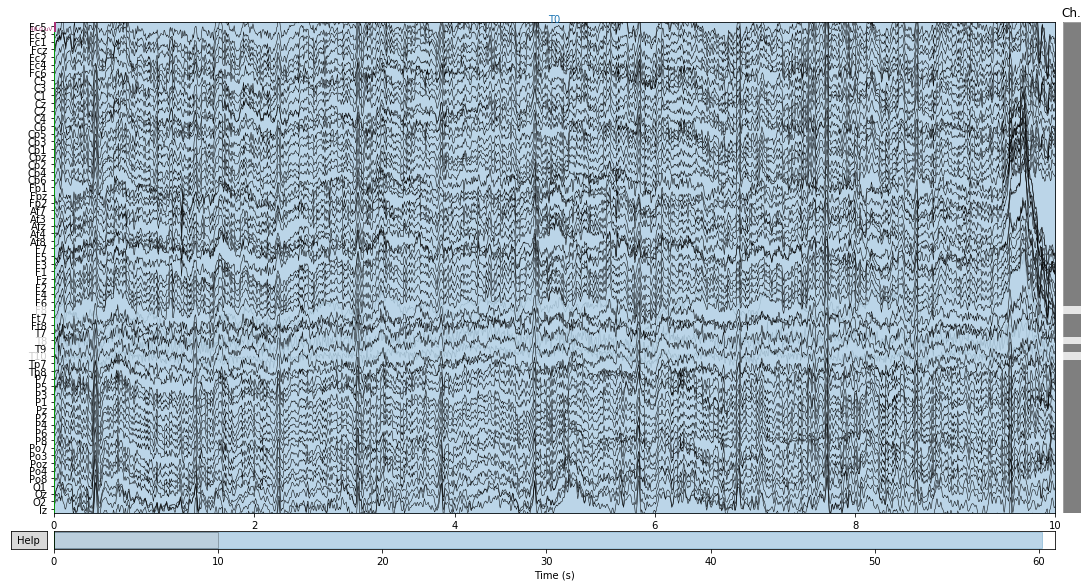

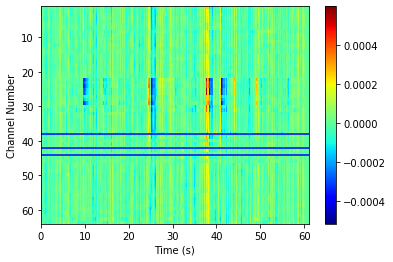

In [8]:
import numpy as np
from scipy.io import loadmat
from statsmodels import robust
import mne
from scipy import signal
from scipy.stats import iqr
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from mne.channels.interpolation import _make_interpolation_matrix
import math
import scipy.interpolate
from cmath import sqrt
import matplotlib.pyplot as plt
#from utilities import filter_design


class bad_channels_detector():
    """
    This class implements the functionality of the `findNoisyChannels` function
    as part of the PREP (preprocessing pipeline) for EEG data described in [1].

    References
    ----------
    [1] Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K. M., Robbins, K. A.
    (2015). The PREP pipeline: standardized preprocessing for large-scale
    EEG analysis. Frontiers in Neuroinformatics, 9, 16.
    """
    def __init__(self, raw, montage_kind='standard_1020'):
        """Initialize the class."""
        # Make sure that we got an MNE object
        assert isinstance(raw, mne.io.BaseRaw)

        self.raw_mne = raw.copy()
        self.EEGData = self.raw_mne.get_data(picks='eeg')
        self.ch_names_original = np.asarray(raw.info["ch_names"])
        self.sample_rate = raw.info["sfreq"]
        self.n_chans_original = len(self.ch_names_original)
        self.signal_len = len(self.raw_mne.times)

        # The identified bad channels
        self.bad_by_nan = []
        self.bad_by_flat = []
        self.bad_by_deviation = []
        self.bad_by_hf_noise = []
        self.bad_by_correlation = []
        self.bad_by_dropout = []
        self.bad_by_ransac = []
        self.noisy_channels = []

    def get_bads(self, verbose=False):
        """Get a list of all bad channels.
        Parameters
        ----------
        verbose : boolean
            If verbose, print a summary of bad channels.
        """
        bads = (self.bad_by_nan + self.bad_by_flat + self.bad_by_deviation + self.bad_by_hf_noise +
                self.bad_by_correlation + self.bad_by_dropout + self.bad_by_ransac)
        bads = list(set(bads))

        if verbose:
            print('Found {} uniquely bad channels.'.format(len(bads)))
            print('\n{} by n/a: {}'.format(len(self.bad_by_nan),
                                           self.bad_by_nan))
            print('\n{} by flat: {}'.format(len(self.bad_by_flat),
                                            self.bad_by_flat))
            print('\n{} by deviation: {}'.format(len(self.bad_by_deviation),
                                                 self.bad_by_deviation))
            print('\n{} by hf noise: {}'.format(len(self.bad_by_hf_noise),
                                                self.bad_by_hf_noise))
            print('\n{} by correl: {}'.format(len(self.bad_by_correlation),
                                              self.bad_by_correlation))
            print('\n{} by dropout: {}'.format(len(self.bad_by_dropout),
                                              self.bad_by_dropout))
            print('\n{} by ransac: {}'.format(len(self.bad_by_ransac),
                                              self.bad_by_ransac))

        return bads

    def find_noisy_channels(self, ransac=True):
        """ High-pass filters and removes line noise from the EEG data. Additionally
         finds channels having Nans, no data, unusually high amplitudes poor correlation,
         high-frequency noise, and bad correlation in the low frequency portion of the signal
         using RANSAC.

         Inspired by the PREP pipleine [1]. Fischler and Bolles RANSAC method was used for
         finding outlier channels [2].

         Parameters
         __________
         ransac: bool
                Whether or not to also fetch the bad_by_ransac channels.
         Raises
         ______
         IOE error
                If too few channels are present to perfom RANSAC

         Returns
         _______
         None

         References
         __________

         [1] Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K., & Robbins, K. (2015).
         The PREP pipeline: standardized preprocessing for large-scale EEG analysis.
         Frontiers In Neuroinformatics, 9. doi: 10.3389/fninf.2015.00016
         [2] Fischler, M., & Bolles, R. (1981). Random sample consensus: a paradigm
         for model fitting with applications to image analysis and automated
         cartography. Communications Of The ACM, 24(6), 381-395. doi: 10.1145/358669.358692

         """

        # finding channels with NaNs or constant values for long periods of time

        original_dimensions = np.shape(self.EEGData)
        original_channels = np.arange(original_dimensions[0])
        channels_interpolate = original_channels
        nan_channel_mask = [False] * original_dimensions[0]
        no_signal_channel_mask = [False] * original_dimensions[0]

        for i in range(0, original_dimensions[0]):
            nan_channel_mask[i] = np.sum(np.isnan(self.EEGData[i, :])) > 0
        for i in range(0, original_dimensions[0]):
            no_signal_channel_mask[i] = robust.mad(self.EEGData[i, :]) < 10 ** (-10) or np.std(
                self.EEGData[i, :]) < 10 ** (-10)
        nan_channels = channels_interpolate[nan_channel_mask]
        flat_channels = channels_interpolate[no_signal_channel_mask]

        nans_no_data_channels = np.union1d(nan_channels, flat_channels)
        channels_interpolate = np.setdiff1d(
            channels_interpolate, nans_no_data_channels)

        for i in range(0, len(nan_channels)):
            self.bad_by_nan.append(self.ch_names_original[nan_channels[i]])
        for i in range(0, len(flat_channels)):
            self.bad_by_flat.append(self.ch_names_original[flat_channels[i]])

        self.raw_mne.drop_channels(list(set(self.bad_by_nan + self.bad_by_flat)))
        self.EEGData_new = self.raw_mne.get_data(picks='eeg')
        self.ch_names_new = np.asarray(self.raw_mne.info["ch_names"])
        self.n_chans_new = len(self.ch_names_new)

        evaluation_channels = channels_interpolate
        new_dimension = np.shape(self.EEGData_new)

        # find channels that have abnormally high or low amplitude
        deviation_channel_mask = [False] * (new_dimension[0])
        channel_deviation = np.zeros(new_dimension[0])
        for i in range(0, new_dimension[0]):
            channel_deviation[i] = 0.7413 * iqr(self.EEGData_new[i, :])
        channel_deviationSD = 0.7413 * iqr(channel_deviation)
        channel_deviationMedian = np.nanmedian(channel_deviation)
        robust_channel_deviation = np.divide(
            np.subtract(channel_deviation, channel_deviationMedian), channel_deviationSD)
        for i in range(0, new_dimension[0]):
            deviation_channel_mask[i] = abs(robust_channel_deviation[i]) > 5 or np.isnan(
                robust_channel_deviation[i])
        deviation_channels = evaluation_channels[deviation_channel_mask]

        for i in range(0, len(deviation_channels)):
            self.bad_by_deviation.append(self.ch_names_original[deviation_channels[i]])

        # finding channels with high frequency noise
        data_tmp = np.transpose(self.EEGData_new)
        dimension = np.shape(data_tmp)
        if self.sample_rate > 100:
            EEG_filt = np.zeros((dimension[0], dimension[1]))
            bandpass_filter = filter_design(
                N_order=100,
                amp=np.array([1, 1, 0, 0]),
                freq=np.array([0, 90/self.sample_rate, 100/self.sample_rate, 1]),
                sample_rate=self.sample_rate)
            for i in range(0, dimension[1]):
                EEG_filt[:, i] = signal.filtfilt(bandpass_filter, 1, data_tmp[:, i])
            noisiness = np.divide(robust.mad(np.subtract(data_tmp, EEG_filt)),
                                  robust.mad(EEG_filt))
            noisiness_median = np.nanmedian(noisiness)
            noiseSD = (np.median(np.absolute(np.subtract(noisiness, np.median(noisiness))))
                       * 1.4826)
            zscore_HFNoise = np.divide(np.subtract(noisiness, noisiness_median), noiseSD)
            HFnoise_channel_mask = [False] * new_dimension[0]
            for i in range(0, new_dimension[0]):
                HFnoise_channel_mask[i] = zscore_HFNoise[i] > 5 or np.isnan(
                    zscore_HFNoise[i])
            HFNoise_channels = evaluation_channels[HFnoise_channel_mask]
        else:
            EEG_filt = data_tmp
            noisiness_median = 0
            noisinessSD = 1
            zscore_HFNoise = np.zeros(dimension[1], 1)
            HFNoise_channels = []
        self.EEG_filt = np.transpose(EEG_filt)
        for i in range(0, len(HFNoise_channels)):
            self.bad_by_hf_noise.append(self.ch_names_original[HFNoise_channels[i]])

        # finding channels by correlation
        CORRELATION_SECONDS = 1  # default value
        CORRELATION_FRAMES = CORRELATION_SECONDS * self.sample_rate
        correlation_window = np.arange(CORRELATION_FRAMES)
        correlation_offsets = np.arange(1, dimension[0] - CORRELATION_FRAMES,
                                        CORRELATION_FRAMES)
        w_correlation = len(correlation_offsets)
        maximum_correlations = np.ones((original_dimensions[0], w_correlation))
        drop_out = np.zeros((dimension[1], w_correlation))
        channel_correlation = np.ones((w_correlation, dimension[1]))
        noiselevels = np.zeros((w_correlation, dimension[1]))
        channel_deviations = np.zeros((w_correlation, dimension[1]))
        drop = np.zeros((w_correlation, dimension[1]))
        len_correlation_window = len(correlation_window)
        EEG_new_win = np.reshape(
            np.transpose(EEG_filt[0: len_correlation_window * w_correlation, :]),
            (dimension[1], len_correlation_window, w_correlation),
            order="F")
        data_win = np.reshape(
            np.transpose(data_tmp[0: len_correlation_window * w_correlation, :]),
            (dimension[1], len_correlation_window, w_correlation),
            order="F")
        for k in range(0, w_correlation):
            eeg_portion = np.transpose(np.squeeze(EEG_new_win[:, :, k]))
            data_portion = np.transpose(np.squeeze(data_win[:, :, k]))
            window_correlation = np.corrcoef(np.transpose(eeg_portion))
            abs_corr = np.abs(
                np.subtract(window_correlation, np.diag(np.diag(window_correlation))))
            channel_correlation[k, :] = np.quantile(
                abs_corr, 0.98, axis=0)  # problem is here is solved
            noiselevels[k, :] = np.divide(
                robust.mad(np.subtract(data_portion, eeg_portion)), robust.mad(eeg_portion))
            channel_deviations[k, :] = 0.7413 * iqr(data_portion, axis=0)
        for i in range(0, w_correlation):
            for j in range(0, dimension[1]):
                drop[i, j] = np.int(
                    np.isnan(channel_correlation[i, j]) or np.isnan(noiselevels[i, j]))
                if drop[i, j] == 1:
                    channel_deviations[i, j] = 0
                    noiselevels[i, j] = 0
        maximum_correlations[evaluation_channels, :] = np.transpose(channel_correlation)
        drop_out[:] = np.transpose(drop)
        noiselevels_out = np.transpose(noiselevels)
        channel_deviations_out = np.transpose(channel_deviations)
        thresholded_correlations = maximum_correlations < 0.4
        thresholded_correlations = thresholded_correlations.astype(int)
        fraction_BadCorrelationWindows = np.mean(thresholded_correlations, axis=1)
        fraction_BadDropOutWindows = np.mean(drop_out, axis=1)

        bad_correlation_channels_idx = np.argwhere(fraction_BadCorrelationWindows > 0.01)
        bad_correlation_channels_name = self.ch_names_original[bad_correlation_channels_idx.astype(int)]
        self.bad_by_correlation = [i[0] for i in bad_correlation_channels_name]

        dropout_channels_idx = np.argwhere(fraction_BadDropOutWindows > 0.01)
        dropout_channels_name = self.ch_names_original[dropout_channels_idx.astype(int)]
        self.bad_by_dropout = [i[0] for i in dropout_channels_name]

        self.noisy_channels = self.get_bads()
        if ransac:
            self._find_bad_by_ransac()
        return self.noisy_channels

    def _find_bad_by_ransac(self, n_samples=50, fraction_good=0.25,
                           corr_thresh=0.75, fraction_bad=0.4,
                           corr_window_secs=5.):
        """Detect channels that are not predicted well by other channels.
        Here, a ransac approach (see [1], and a short discussion in [2]) is
        adopted to predict a "clean EEG" dataset. After identifying clean EEG
        channels through the other methods, the clean EEG dataset is
        constructed by repeatedly sampling a small subset of clean EEG channels
        and interpolation the complete data. The median of all those
        repetitions forms the clean EEG dataset. In a second step, the original
        and the ransac predicted data are correlated and channels, which do not
        correlate well with themselves across the two datasets are considered
        `bad_by_ransac`.
        Parameters
        ----------
        n_samples : int
            Number of samples used for computation of ransac.
        fraction_good : float
            Fraction of channels used for robust reconstruction of the signal.
            This needs to be in the range [0, 1], where obviously neither 0
            nor 1 would make sense.
        corr_thresh : float
            The minimum correlation threshold that should be attained within a
            data window.
        fraction_bad : float
            If this percentage of all data windows in which the correlation
            threshold was not surpassed is exceeded, classify a
            channel as `bad_by_ransac`.
        corr_window_secs : float
            Size of the correlation window in seconds.
        References
        ----------
        .. [1] Fischler, M.A., Bolles, R.C. (1981). Random rample consensus: A
           Paradigm for Model Fitting with Applications to Image Analysis and
           Automated Cartography. Communications of the ACM, 24, 381-395
        .. [2] Jas, M., Engemann, D.A., Bekhti, Y., Raimondo, F., Gramfort, A.
           (2017). Autoreject: Automated Artifact Rejection for MEG and EEG
           Data. NeuroImage, 159, 417-429
        """
        # First, identify all bad channels by other means:
        bads = self.get_bads()

        # Get all channel positions and the position subset of "clean channels"
        good_idx = mne.pick_channels(list(self.ch_names_new), include=[], exclude=bads)
        good_chn_labs = self.ch_names_new[good_idx]
        n_chans_good = good_idx.shape[0]
        chn_pos = self.raw_mne._get_channel_positions()
        chn_pos_good = chn_pos[good_idx, :]

        # Check if we have enough remaning channels
        # after exclusion of bad channels
        n_pred_chns = int(np.ceil(fraction_good * n_chans_good))

        if n_pred_chns <= 3:
            raise IOError('Too few channels available to reliably perform'
                          ' ransac. Perhaps, too many channels have failed'
                          ' quality tests.')

        # Make the ransac predictions
        ransac_eeg = self._run_ransac(chn_pos=chn_pos,
                                      chn_pos_good=chn_pos_good,
                                      good_chn_labs=good_chn_labs,
                                      n_pred_chns=n_pred_chns,
                                      data=self.EEG_filt,
                                      n_samples=n_samples)

        # Correlate ransac prediction and eeg data
        correlation_frames = corr_window_secs * self.sample_rate
        correlation_window = np.arange(correlation_frames)
        n = correlation_window.shape[0]
        correlation_offsets = np.arange(0, (self.signal_len -
                                            correlation_frames),
                                        correlation_frames)
        w_correlation = correlation_offsets.shape[0]

        # For the actual data
        data_window = self.EEG_filt[:self.n_chans_new, :n * w_correlation]
        data_window = data_window.reshape(self.n_chans_new, n, w_correlation)

        # For the ransac predicted eeg
        pred_window = ransac_eeg[:self.n_chans_new, :n * w_correlation]
        pred_window = pred_window.reshape(self.n_chans_new, n, w_correlation)

        # Preallocate
        channel_correlations = np.ones((w_correlation, self.n_chans_new))

        # Perform correlations
        for k in range(w_correlation):
            data_portion = data_window[:, :, k]
            pred_portion = pred_window[:, :, k]

            R = np.corrcoef(data_portion, pred_portion)

            # Take only correlations of data with pred
            # and use diag to exctract correlation of
            # data_i with pred_i
            R = np.diag(R[0:self.n_chans_new, self.n_chans_new:])
            channel_correlations[k, :] = R

        # Thresholding
        thresholded_correlations = channel_correlations < corr_thresh
        frac_bad_corr_windows = np.mean(thresholded_correlations, axis=0)

        # find the corresponding channel names and return
        bad_ransac_channels_idx = np.argwhere(frac_bad_corr_windows > fraction_bad)
        bad_ransac_channels_name = self.ch_names_new[bad_ransac_channels_idx.astype(int)]
        self.bad_by_ransac = [i[0] for i in bad_ransac_channels_name]
        # self._ransac_channel_correlations = channel_correlations
        self.noisy_channels = list(set(self.noisy_channels + self.bad_by_ransac))
        return None

    def _run_ransac(self, chn_pos, chn_pos_good, good_chn_labs, n_pred_chns, data, n_samples):
        """Detects noisy channels apart from the ones described previously. It creates
        a random subset of the so-far good channels
        and predicts the values of the channels not in the subset.
        Parameters
        __________
        chn_pos: ndarray
                 3-D coordinates of the electrode position
        chn_pos_good: ndarray
                      3-D coordinates of all the channels not detected noisy so far
        good_chn_labs: array_like
                        channel labels for the ch_pos_good channels-
        n_pred_chns: int
                     channel numbers used for interpolation for RANSAC
        data: ndarry
              2-D EEG data
        n_samples: int
                    number of interpolations from which a median will be computed

        Returns
        _______
        ransac_eeg: ndarray
                    The EEG data predicted by RANSAC
        Title: noisy
        Author: Stefan Appelhoff
        Date: 2018
        Availability: https://github.com/sappelhoff/pyprep/blob/master/pyprep/noisy.py
        """

        # Make the predictions
        n_chns, n_timepts = data.shape
        eeg_predictions = np.zeros((n_chns, n_timepts, n_samples))
        for sample in range(n_samples):
            eeg_predictions[..., sample] = self._get_ransac_pred(chn_pos,
                                                                 chn_pos_good,
                                                                 good_chn_labs,
                                                                 n_pred_chns,
                                                                 data)

        # Form median from all predictions
        ransac_eeg = np.median(eeg_predictions, axis=-1, overwrite_input=True)
        return ransac_eeg

    def _get_ransac_pred(self, chn_pos, chn_pos_good, good_chn_labs, n_pred_chns, data):
        """Performs RANSAC prediction
            Parameters
            __________
            chn_pos: ndarray
                     3-D coordinates of the electrode position
            chn_pos_good: ndarray
                          3-D coordinates of all the channels not detected noisy so far
            good_chn_labs: array_like
                            channel labels for the ch_pos_good channels
            n_pred_chns: int
                         channel numbers used for interpolation for RANSAC
            data: ndarry
                  2-D EEG data

            Returns
            _______
            ransac_pred: ndarray
                        Single RANSAC prediction
            Title: noisy
            Author: Stefan Appelhoff
            Date: 2018
            Availability: https://github.com/sappelhoff/pyprep/blob/master/pyprep/noisy.py
    """
        # Pick a subset of clean channels for reconstruction
        reconstr_idx = np.random.choice(np.arange(chn_pos_good.shape[0]),
                                        size=n_pred_chns,
                                        replace=False)

        # Get positions and according labels
        reconstr_labels = good_chn_labs[reconstr_idx]
        reconstr_pos = chn_pos_good[reconstr_idx, :]

        # Map the labels to their indices within the complete data
        # Do not use mne.pick_channels, because it will return a sorted list.
        reconstr_picks = [list(self.ch_names_new).index(chn_lab) for chn_lab
                          in reconstr_labels]

        # Interpolate
        interpol_mat = _make_interpolation_matrix(reconstr_pos, chn_pos)
        ransac_pred = np.matmul(interpol_mat, data[reconstr_picks, :])
        return ransac_pred

def filter_design(N_order, amp, freq, sample_rate):
    """Creates a FIR low-pass filter that filters the EEG data using frequency
    sampling method.

    Parameters
    __________
    N_order: int
             order of the filter
    amp: list of int
         amplitude vector for the frequencies
    freq: list of int
          frequency vector for which amplitude can be either 0 or 1
    sample_rate: int
          Sampling rate of the EEG signal
    Returns
    _______
    kernel: ndarray
            filter kernel

    """
    nfft = np.maximum(512, 2 ** (np.ceil(math.log(100) / math.log(2))))
    hamming_window = np.subtract(0.54, np.multiply(0.46, np.cos(
        np.divide(np.multiply(2 * math.pi, np.arange(N_order + 1)), N_order))))
    pchip_interpolate = scipy.interpolate.PchipInterpolator(np.round(np.multiply
                                                            (nfft, freq)), amp)
    freq = pchip_interpolate(np.arange(nfft + 1))
    freq = np.multiply(freq,
                       np.exp(np.divide(np.multiply(-(0.5 * N_order) * sqrt(-1) *
                        math.pi, np.arange(nfft + 1)), nfft)))
    kernel = np.real(np.fft.ifft(np.concatenate
                                 ([freq, np.conj(freq[len(freq) - 2:0:-1])])))
    kernel = np.multiply(kernel[0:N_order + 1],
                         (np.transpose(hamming_window[:])))
    return kernel

raw = mne.io.read_raw_edf("C:\\Users\\Aamna\\Desktop\\NDD\\S001R01.edf", preload=True)
raw.rename_channels(lambda s: s.strip("."))
a=mne.channels.read_montage(kind='standard_1020',ch_names=raw.info['ch_names'])
mne.set_log_level("WARNING")
raw.set_montage(a)
eeg=raw.get_data()
#eeg[3,:]=0
#eeg[5,:]=eeg[5,:]/10
#np.random.shuffle(eeg)
#raw2=mne.io.RawArray(eeg,raw.info)
nd=bad_channels_detector(raw)
bads=nd.find_noisy_channels()
nd.get_bads(verbose=True)
raw.info['bads']=bads
sh=np.shape(eeg)
raw.plot(block=True,n_channels=64)
#calculating the index numbers for plotting
index=[]
x=np.arange(0,eeg.shape[1],1/160)
ch=raw.info['ch_names']
for i in range(0,len(bads)):
    for j in range(0,len(ch)):
        if bads[i]==ch[j]:
            index.append(j+1)
plt.imshow(eeg,aspect='auto',extent=[0, (eeg.shape[1]/160), 64,1])
for i in range(0,len(index)):
    plt.plot(np.ones(eeg.shape[1])*index[i],color="blue")
    plt.xlim([0, eeg.shape[1]/160])
plt.jet()
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Channel Number')
plt.show()






#a = loadmat('C:\\Users\\Aamna\\Desktop\\NDD\\A01ChannelData.mat')
#ch_names = ['Fz', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp3', 'Cp1', 'Cpz','Cp2', 'Cp4', 'P1', 'Pz', 'P2', 'Poz']
#sfreq = 250
#eeg = a['ChannelData']
#eeg[19:22, :] = eeg[22:25, :]
#eeg[1, :] = eeg[1, :] / 10
#eeg[4,:]=0
#eeg[6,:]=0
#noise=10*np.random.normal(0,1,eeg.shape[1])
#eeg[9,:]=eeg[2,:]+noise
#eeg = eeg[0:22, :]
#n_chans = 22
#X = eeg*1e-6
#info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * n_chans)
#raw = mne.io.RawArray(X, info)
#a = mne.channels.read_montage(kind='standard_1020', ch_names=raw.info['ch_names'])
#raw.set_montage(a)

#nd=bad_channels_detector(raw)
#bads=nd.find_noisy_channels()
#raw.info['bads']=bads
#raw.plot(block=True, n_channels=22)